In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import scipy as sp

In [82]:
from sklearn.decomposition import PCA
data = pd.read_csv("pinsoro-2017-06-01-102743523980-small.csv", low_memory=False)

dt = 0.001

pattern = np.array(data.iloc[2977:3379,11:195]).astype(float)
frames = np.array(data.iloc[2977:3379,9]).astype(int)
    
good_indices = frames != -1
frames = frames[good_indices]
pattern = pattern[good_indices]

fps = 30.0
t_sample = (frames - frames[0])/fps

t = np.arange(int(t_sample[-1]/dt))*dt

p = sp.interpolate.interp2d(t_sample, pattern, t)
    


ValueError: x and y must have equal lengths for non rectangular grid

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (222) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(13333,)

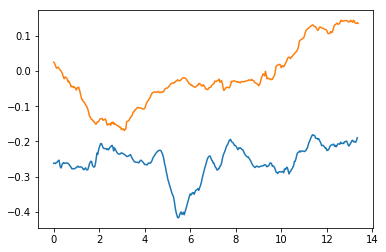

In [65]:
data = pd.read_csv("pinsoro-2017-06-01-102743523980-small.csv")

dt = 0.001


def extract_pattern(start, end):
    pattern = np.array(data.iloc[start:end,190]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/dt))*dt

    p = np.interp(t, t_sample, pattern)

    return t, p


t1, p1 = extract_pattern(2977, 3379)
t2, p2 = extract_pattern(3702, 4104)
plt.plot(t1, p1)
plt.plot(t2, p2)


Pattern 1 is goal oriented play. 
Pattern 2 is no-play. 

Now let's create a network that represents a rolling window in time (Aaron's "delay network"). The process determines what sort of pattern the network will be optimized for -- here we just go with white noise of a maximum of 3Hz.  theta determines how big the rolling window is -- here we use 0.5 seconds.

In [3]:
theta = 1.0

net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
    rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Now we need to create the training data for decoding out of the rolling window. Our patterns are larger than the rolling window, so to create our training data we will take our patterns, shift them, and cut them down to the right size. In order to then give that to nengo, we also need to project from the window's space to the internal representation space (using the inv_basis).

The target array is the desired output value for each of the slices of the pattern in eval_points. We'll use 1 for pattern1 and -1 for pattern2.

In [4]:
s_window = int(theta/dt)
s_pattern = min(len(p1), len(p2))

t_window = np.linspace(0, 1, s_window)
inv_basis = rw.inverse_basis(t_window)
    
eval_points=[]
target = []
for i in range(s_pattern):
    eval_points.append(np.dot(inv_basis, np.roll(p1, i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(p2, i)[:s_window]))
    target.append([-1])
    
eval_points = np.array(eval_points)
print(eval_points.shape)

(26666, 6)


Now we can create a connection optimized to do this decoding

In [5]:
with net:
    result = nengo.Node(None, size_in=1)
    nengo.Connection(rw.state, result,
                     eval_points=eval_points, scale_eval_points=True,
                     function=target, synapse=0.1)

Let's try feeding in those two patterns and see what the response is

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

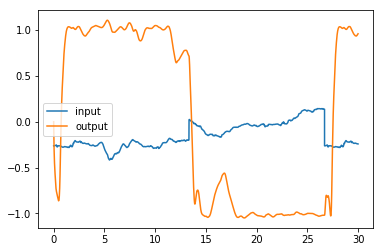

In [6]:
p_all = np.hstack([p1, p2])

model = nengo.Network()
model.networks.append(net)
with model:    
    stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=0.001))
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(30)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')